## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [4]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

To clean the tokens and use them to predict whether the email is a phishing scam or not, I would first remove all special characters and punctuations as well as common words such as "a", "an", "and", "the", etc. Then, I would encode the tokens for each email as features using one-hot-encoding so that I can run an algorithm that uses the presence of tokens as a way to predict whether the email is a scam/phishing email. I would probably run a PCA or linear models to do this.

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [6]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

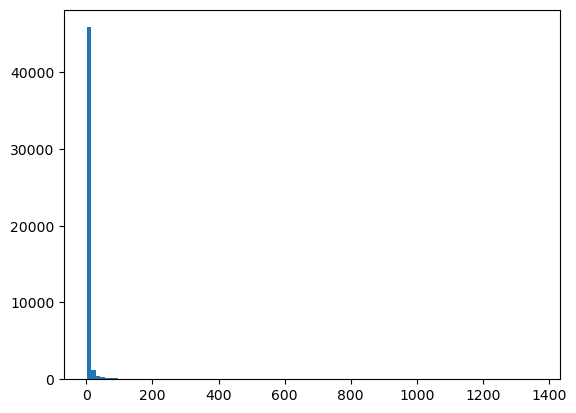

In [14]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

gdf['count'].describe()

# Seems like for the most part, most of the tokens only appear once since up to 50th percentile of the tokens appeared only once.
# Even with the 75th percentile, the tokens only appeared twice. However, it's obvious that there is a (or several) token that 
# appeared a max of 1365 times, which makes this plot very hard to view and hard for us to predict the email as a scam,
# especially if a token only appears only a few times.

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [20]:
df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)   

In [25]:
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)

y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)

print('Train R2: ', r2_score(y_hat_train_0, y_train))
print('Test R2: ', r2_score(y_hat_test_0, y_test))

# The R2 score on the train set is 0.6213594179941584 and on the test set is -0.00026838432729769934.

Train R2:  0.6213594179941584
Test R2:  -0.00026838432729769934


In [22]:
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

# Seems like the words with the largest coefficients in absolute value and strongly influence predictions are just numbers such
# as 1995, 000, -0400, 200, and 1st...

,variable,value,abs
421,1995,1.456345e+13,1.456345e+13
96,000,1.121898e+13,1.121898e+13
1146,-0400,8.578403e+12,8.578403e+12
1061,200,6.327881e+12,6.327881e+12
1341,1st,-5.832794e+12,5.832794e+12
...,...,...,...
349,support,-6.866455e-04,6.866455e-04
1909,senate,6.790161e-04,6.790161e-04
1298,distribution,-5.111694e-04,5.111694e-04
457,due,-3.833771e-04,3.833771e-04


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

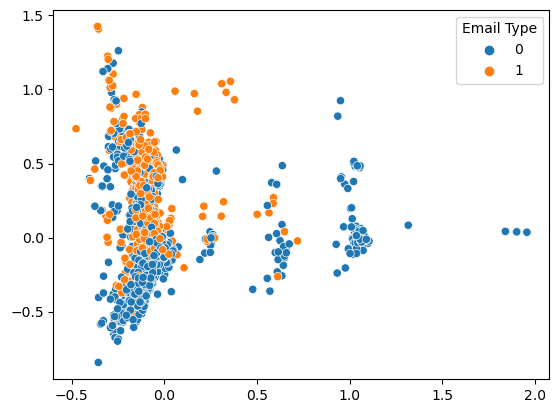

In [23]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0], y=Z_test[:,1], hue=y_test)

Seems like the scam/phishing points (orange) have a higher second components and lower first component. This could be a way for us to separate the scam/phishing points from the non-phishing emails.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [26]:
reduction = PCA(n_components=2610).fit(X_train)

Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train, y_train)

y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train R2: ', r2_score(y_hat_train, y_train))
print('Test R2: ', r2_score(y_hat_test, y_test))    

# The R2 score on the training set is 0.6928975360963749 and on the test set is 0.587390597321718.
# Compared to the linear regression, it is so much better, especially the R2 score of the test set. 

Train R2:  0.6928975360963749
Test R2:  0.587390597321718


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The advantage of using the principal components to run this high-dimensional regression is that multi-colinearity does not arise due to the features and covariates being made independent and orthogonal because of PCA decomposition. We can interpret words easier instead of the components. 


Because the features/covariates are made independent/orthogonal by way of the PCA decomposition, multi-colinearity doesn't arise. It's also easier to decide whether to include 1, 2, ..., 2711 components, rather than  22711
  possible packages of components. On the other hand, we can interpret words, but not what the components themselves are.